In [1]:
%pylab inline
from useful_function import *
from sklearn.svm import SVDD
import pandas as pd
from sklearn.metrics import roc_auc_score

Populating the interactive namespace from numpy and matplotlib


In [3]:
def slice_probability_metric(clf, train_x, rho=0.111111):
    clf.fit(train_x)
    positive_error = mean(clf.predict(train_x) == -1)
    positive_error /= (1 + rho)
    synthetic_anomalies = rand(1000, train_x.shape[1]) - 0.5
    synthetic_anomalies *= 4 * (train_x.max() - train_x.min())
    negative_errors = mean(clf.predict(synthetic_anomalies) == 1)
    negative_errors *= rho/(1 + rho)
    return negative_errors + positive_error

In [4]:
train_x = generate_dataset(500, dim=2)
train, test = split_data_set(train_x, 2)
inliers, outliers = split_anomaly_normal_data(test, outliers_fraction=0.1)
train = train.iloc[:, :-1]
test = test.iloc[:, :-1]

In [5]:
all_gammas = logspace(-10, 10, 50)

In [126]:
results_their = []
for gamma in all_gammas:
    C = (len(train_x) * 0.1) ** (-1)
    clf = SVDD(C=C,kernel='rbf', gamma=gamma)
    results_their.append(slice_probability_metric(clf, test))

In [127]:
def validate_classifier_by_random_points(all_gammas, train_x, size=1000):
    all_values = []
    positive_points = SMOTE(train_x, k=5,n_samples=size)
    negative_points = rand(size, train_x.shape[1]) - 0.5
    negative_points *= 4 * (train_x.max() - train_x.min())
    for gamma in all_gammas:
        C = 1.0 / len(train_x) / 0.1
        clf = SVDD(kernel='rbf', gamma=gamma, C=C)
        clf.fit(train_x)
        error = mean(clf.predict(positive_points) == -1)
        error += mean(clf.predict(negative_points) == 1)
        all_values.append(error)
    return all_values


In [128]:
results_our = validate_classifier_by_random_points(all_gammas, train)

In [129]:
results_auc = []
for gamma in all_gammas:
    C = (len(train_x) * 0.1) ** (-1)
    clf = SVDD(C=C, kernel='rbf', gamma=gamma).fit(train)
    results = mean(clf.predict(inliers) == -1)
    results += mean(clf.predict(outliers * 50) == 1)
    #results = -1 * concatenate([clf.decision_function(inliers), clf.decision_function(outliers)])
    #true_results = [0] * len(inliers) + [1] * len(outliers)
    #error = roc_auc_score(true_results, results, average='weighted')
    results_auc.append(results)

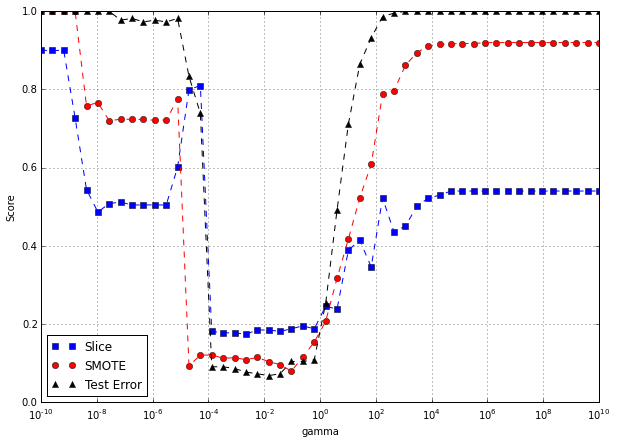

In [130]:
figsize(10, 7)
plot(all_gammas, results_their,'bs', label='Slice')
plot(all_gammas, results_their,'b--')
plot(all_gammas, results_our, 'ro', label='SMOTE')
plot(all_gammas, results_our, 'r--')
plot(all_gammas, results_auc, 'k^', label='Test Error')
plot(all_gammas, results_auc, 'k--')

legend(loc='best')
xlabel('gamma')
ylabel('Score')
grid(True)
xscale('log')

In [20]:
def process_data_set(data):
    normal_data, anomaly_data = split_anomaly_normal_data(data)
    selection_technics = [validate_classifier_by_random_points, slice_probability_metric]
    normal_train, normal_validate, normal_test = split_data_set(normal_data, 3)
    anomaly_train, anomaly_validate, anomaly_test = split_data_set(anomaly_data, 3)
    results = {}
    all_gammas = np.logspace(-10, 10, 50)
    for technic in selection_technics:
        start = time.time()
        metrics = model_selection(concatenate([normal_validate, anomaly_validate]), all_gammas, technic)
        duration = time.time() - start
        best_index = np.argmin(metrics)
        best_score = metrics[best_index]
        all_best_gamma = metrics == best_score
        possible_results = all_gammas[all_best_gamma]
        best_gamma = np.max(possible_results)
        fn, fp, auc = validate_gamma(concatenate([normal_train, anomaly_train]), normal_test, anomaly_test, best_gamma)
        results[str(technic).split()[1]] = {'false negative': fn, 'false positive': fp, 'auc': auc, 'time':duration}
    return results

In [29]:
results = {}
for data_set in os.listdir('./csv_data_set/'):
    try:
        data = pd.read_csv('./csv_data_set/{}'.format(data_set))
        tmp = process_data_set(data)
        print tmp
        results[data_set] = tmp
    except:
        pass

{'slice_probability_metric': {'false positive': 0.92233009708737868, 'auc': 0.40012749903330652, 'false negative': 0.017222820236813777, 'time': 8.842736959457397}, 'validate_classifier_by_random_points': {'false positive': 0.86407766990291257, 'auc': 0.37854672003511447, 'false negative': 0.051668460710441337, 'time': 71.82713103294373}}
{'slice_probability_metric': {'false positive': 0.0, 'auc': 0.90000000000000002, 'false negative': 1.0, 'time': 0.02032613754272461}, 'validate_classifier_by_random_points': {'false positive': 0.0, 'auc': 0.5, 'false negative': 1.0, 'time': 3.397092819213867}}
{'slice_probability_metric': {'false positive': 0.0, 'auc': 0.92500000000000004, 'false negative': 0.61458333333333337, 'time': 0.07831788063049316}, 'validate_classifier_by_random_points': {'false positive': 0.0, 'auc': 0.92500000000000004, 'false negative': 0.61458333333333337, 'time': 5.274726867675781}}
{'slice_probability_metric': {'false positive': 0.0, 'auc': 0.5, 'false negative': 1.0, '

In [18]:
def model_selection(data, all_gammas, selection_technic):
    metrics = zeros(all_gammas.shape[0])
    for index, gamma in enumerate(all_gammas):
        clf = SVDD(C = 1.0 / 100, gamma=gamma, kernel='rbf')
        metrics[index] = selection_technic(clf, data)
    return metrics

In [17]:
all_gammas

array([  1.00000000e-10,   2.55954792e-10,   6.55128557e-10,
         1.67683294e-09,   4.29193426e-09,   1.09854114e-08,
         2.81176870e-08,   7.19685673e-08,   1.84206997e-07,
         4.71486636e-07,   1.20679264e-06,   3.08884360e-06,
         7.90604321e-06,   2.02358965e-05,   5.17947468e-05,
         1.32571137e-04,   3.39322177e-04,   8.68511374e-04,
         2.22299648e-03,   5.68986603e-03,   1.45634848e-02,
         3.72759372e-02,   9.54095476e-02,   2.44205309e-01,
         6.25055193e-01,   1.59985872e+00,   4.09491506e+00,
         1.04811313e+01,   2.68269580e+01,   6.86648845e+01,
         1.75751062e+02,   4.49843267e+02,   1.15139540e+03,
         2.94705170e+03,   7.54312006e+03,   1.93069773e+04,
         4.94171336e+04,   1.26485522e+05,   3.23745754e+05,
         8.28642773e+05,   2.12095089e+06,   5.42867544e+06,
         1.38949549e+07,   3.55648031e+07,   9.10298178e+07,
         2.32995181e+08,   5.96362332e+08,   1.52641797e+09,
         3.90693994e+09,